In [1]:
##
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] =  False

In [2]:
##
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [3]:
#
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB
None


,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [4]:
##
df =  df.set_index('timestamp').resample("H").mean()
df

,value
timestamp,
2014-07-01 00:00:00,9485.5
2014-07-01 01:00:00,5433.0
2014-07-01 02:00:00,3346.5
2014-07-01 03:00:00,2216.5
2014-07-01 04:00:00,2189.5
...,...
2015-01-31 19:00:00,28288.5
2015-01-31 20:00:00,24138.0
2015-01-31 21:00:00,24194.5


In [5]:
##
fig = px.line(df.reset_index(), x = 'timestamp', y = 'value', title = 'NYC Taxi Demand')
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list(
            [
             dict(count = 1, label = '1y', step = "year", stepmode = 'backward'),
             dict(count = 2, label = '3y', step = "year", stepmode = 'backward'),
             dict(count = 3, label = '5y', step = "year", stepmode = 'backward'),
             dict(step = "all"),
            ]
        )
    )
)

fig.show()

In [6]:
##
from fbprophet import Prophet

In [7]:
taxi_df = df.reset_index()[['timestamp', 'value']].rename({'timestamp':'ds', 'value':'y'}, axis = 'columns')
taxi_df

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [8]:
train = taxi_df[(taxi_df['ds'] >= '2014-07-01') & (taxi_df['ds'] <= '2015-01-27')]
test = taxi_df[(taxi_df['ds'] > '2015-01-27')]

print(train.shape)
print(test.shape)

(5041, 2)
(119, 2)


In [9]:
test

,ds,y
5041,2015-01-27 01:00:00,39.5
5042,2015-01-27 02:00:00,29.0
5043,2015-01-27 03:00:00,9.5
5044,2015-01-27 04:00:00,14.5
5045,2015-01-27 05:00:00,29.0
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [10]:
##
m = Prophet(changepoint_range=0.95)
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [11]:
##
future = m.make_future_dataframe(periods=119, freq='H') ## 119 rows in test dataframe
future

,ds
0,2014-07-01 00:00:00
1,2014-07-01 01:00:00
2,2014-07-01 02:00:00
3,2014-07-01 03:00:00
4,2014-07-01 04:00:00
...,...
5155,2015-01-31 19:00:00
5156,2015-01-31 20:00:00
5157,2015-01-31 21:00:00
5158,2015-01-31 22:00:00


In [12]:
##
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2014-07-01 00:00:00,13228.339092,8828.339881,18054.458593
1,2014-07-01 01:00:00,10220.194393,5267.611641,15354.883517
2,2014-07-01 02:00:00,6656.895387,1984.363700,11486.917668
3,2014-07-01 03:00:00,3435.918478,-1207.147812,8076.386329
4,2014-07-01 04:00:00,2005.330278,-3085.624633,6804.841788
...,...,...,...,...
5155,2015-01-31 19:00:00,23799.138475,18948.682930,28335.984047
5156,2015-01-31 20:00:00,24363.213509,19050.349643,29098.196896
5157,2015-01-31 21:00:00,23239.944146,18578.264647,27837.425087
5158,2015-01-31 22:00:00,21048.028181,16126.754116,25700.705881


In [13]:
## 
results = pd.concat([taxi_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]], axis=1)

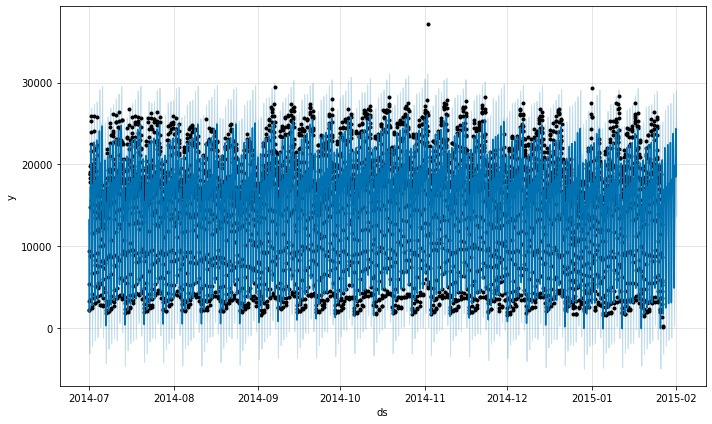

In [14]:
fig1 = m.plot(forecast)

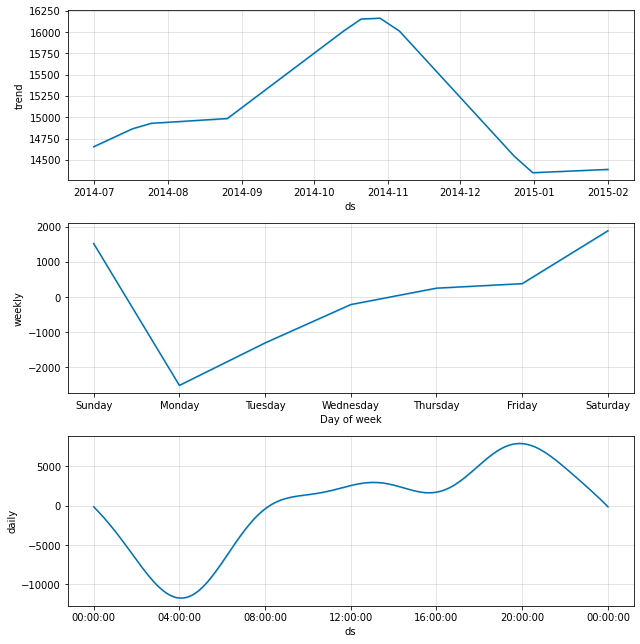

In [15]:
##
comp = m.plot_components(forecast)

In [16]:
results

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,9485.5,13228.339092,8828.339881,18054.458593
2014-07-01 01:00:00,5433.0,10220.194393,5267.611641,15354.883517
2014-07-01 02:00:00,3346.5,6656.895387,1984.363700,11486.917668
2014-07-01 03:00:00,2216.5,3435.918478,-1207.147812,8076.386329
2014-07-01 04:00:00,2189.5,2005.330278,-3085.624633,6804.841788
...,...,...,...,...
2015-01-31 19:00:00,28288.5,23799.138475,18948.682930,28335.984047
2015-01-31 20:00:00,24138.0,24363.213509,19050.349643,29098.196896
2015-01-31 21:00:00,24194.5,23239.944146,18578.264647,27837.425087


In [17]:
##
results['error'] = results['y'] - results['yhat']

In [18]:
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']

In [19]:
results

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-07-01 00:00:00,9485.5,13228.339092,8828.339881,18054.458593,-3742.839092,9226.118711
2014-07-01 01:00:00,5433.0,10220.194393,5267.611641,15354.883517,-4787.194393,10087.271876
2014-07-01 02:00:00,3346.5,6656.895387,1984.363700,11486.917668,-3310.395387,9502.553968
2014-07-01 03:00:00,2216.5,3435.918478,-1207.147812,8076.386329,-1219.418478,9283.534141
2014-07-01 04:00:00,2189.5,2005.330278,-3085.624633,6804.841788,184.169722,9890.466421
...,...,...,...,...,...,...
2015-01-31 19:00:00,28288.5,23799.138475,18948.682930,28335.984047,4489.361525,9387.301116
2015-01-31 20:00:00,24138.0,24363.213509,19050.349643,29098.196896,-225.213509,10047.847253
2015-01-31 21:00:00,24194.5,23239.944146,18578.264647,27837.425087,954.555854,9259.160440


In [20]:
results[results['error'].abs() > 1.5*results['uncertainty']] ## 

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-11-02 01:00:00,37204.5,14215.495541,9146.435814,18718.602072,22989.004459,9572.166258
2015-01-01 01:00:00,29292.0,11402.685988,6842.327609,16234.295130,17889.314012,9391.967522
2015-01-01 02:00:00,25753.5,7767.243272,3014.116650,12460.667183,17986.256728,9446.550533
2015-01-01 03:00:00,22067.0,4476.113854,-69.928988,9078.455025,17590.886146,9148.384012
2015-01-26 19:00:00,4565.5,19788.034941,15411.907923,24418.173684,-15222.534941,9006.265761
2015-01-26 20:00:00,3630.5,20563.358247,15813.832254,25257.496325,-16932.858247,9443.664071
2015-01-26 21:00:00,2907.0,19664.535017,15202.502832,24795.385242,-16757.535017,9592.882410
2015-01-26 22:00:00,1324.5,17708.853168,12804.839690,22547.542120,-16384.353168,9742.702430
2015-01-26 23:00:00,243.0,15428.310469,10768.770334,20060.970736,-15185.310469,9292.200402


In [22]:
##
results['anomaly'] = results.apply(lambda x: 'Yes' if (np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis=1)
results

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
ds,,,,,,,
2014-07-01 00:00:00,9485.5,13228.339092,8828.339881,18054.458593,-3742.839092,9226.118711,No
2014-07-01 01:00:00,5433.0,10220.194393,5267.611641,15354.883517,-4787.194393,10087.271876,No
2014-07-01 02:00:00,3346.5,6656.895387,1984.363700,11486.917668,-3310.395387,9502.553968,No
2014-07-01 03:00:00,2216.5,3435.918478,-1207.147812,8076.386329,-1219.418478,9283.534141,No
2014-07-01 04:00:00,2189.5,2005.330278,-3085.624633,6804.841788,184.169722,9890.466421,No
...,...,...,...,...,...,...,...
2015-01-31 19:00:00,28288.5,23799.138475,18948.682930,28335.984047,4489.361525,9387.301116,No
2015-01-31 20:00:00,24138.0,24363.213509,19050.349643,29098.196896,-225.213509,10047.847253,No
2015-01-31 21:00:00,24194.5,23239.944146,18578.264647,27837.425087,954.555854,9259.160440,No


In [24]:
##
fig = px.scatter(results.reset_index(), x = 'ds', y = 'y', color='anomaly', title = 'NYC Taxi Demand')
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list(
            [
             dict(count = 1, label = '1y', step = "year", stepmode = 'backward'),
             dict(count = 2, label = '3y', step = "year", stepmode = 'backward'),
             dict(count = 3, label = '5y', step = "year", stepmode = 'backward'),
             dict(step = "all"),
            ]
        )
    )
)

fig.show()

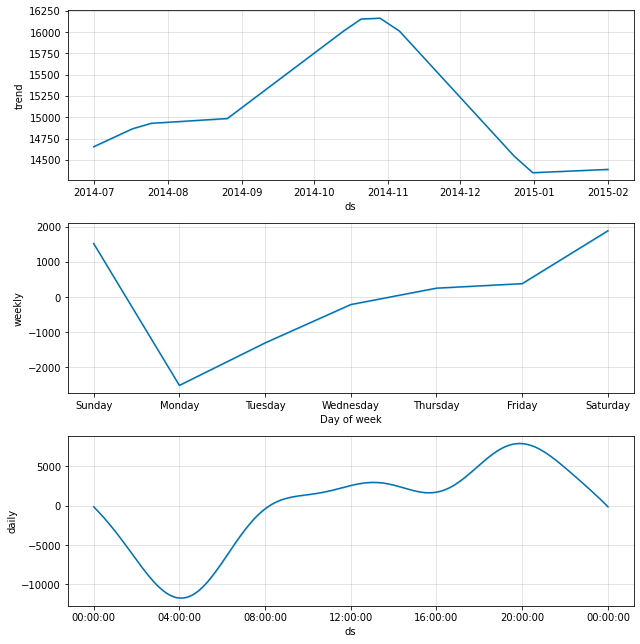

In [25]:
comp = m.plot_components(forecast)